**Description**: Contains the solution to Problem B. Contributions: Lombardi 50%, Bertoni 50%.

# Problem B.1: Fitting a standard GP

In [ ]:
# Install necessary packages
!pip install pyro-ppl
!pip install arviz

# Import libreries
import torch
import torch.nn as nn
import numpy as np
import torch.distributions as dist
from torch.distributions import constraints
from torch.distributions.transforms import AffineTransform
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.optim import Adam
import arviz as az

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 27.2 MB/s eta 0:00:00


Check CUDA availability, set device, and define a function to generate the dataset:

In [ ]:
# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

l = 30  # total number of points
g = lambda x: - torch.sin(6 * np.pi * x) ** 2 + 6 * x ** 2 - 5 * x ** 4 + 3 / 2 # true underlying function

def generate_dataset(seed=3):
    # Set seed for reproducibility
    torch.manual_seed(seed)

    # Generate the dataset
    x = torch.linspace(0, 1, l).to(device)  # input grid
    g = lambda x: - torch.sin(6 * np.pi * x) ** 2 + 6 * x ** 2 - 5 * x ** 4 + 3 / 2 # true underlying function
    y = g(x) + torch.randn_like(x) * 0.1  # observations with noise

    # Split into training and evaluation
    indices = torch.randperm(l).to(device)
    num_training = int(torch.round(torch.tensor(l * 2 / 3)).item())
    train_idx = indices[:num_training]
    test_idx = indices[num_training:]

    x_train, y_train_raw = x[train_idx], y[train_idx]
    x_test, y_test_raw = x[test_idx], y[test_idx]

    # Order x_test in increasing order and y_test accordingly
    sorted_indices = torch.argsort(x_test, dim=0)
    x_test = x_test[sorted_indices]
    y_test_raw = y_test_raw[sorted_indices]

    return x_train, y_train_raw, x_test, y_test_raw

Using device: cpu


Define a class for the Gaussian Process model. The methods in this class already contain the essential code to solve problem B.1. In the following code blocks, we will see these methods in action.

In [ ]:
# Our prior distribution for the period parameter
shift = torch.tensor(1.0).to(device)
ShiftedLogNormal = dist.TransformedDistribution(
    dist.LogNormal(0.0, 1),
    [AffineTransform(loc=shift, scale=1.0)]
)

# Definition of the pyro model of the GP, we will use it in the class below to sample from the posterior using NUTS
class GPModel:
    def __init__(self, x_train, y_train, noise_variance, kernel_func):
        self.x_train = x_train
        self.y_train = y_train
        self.noise_variance = noise_variance
        self.kernel_func = kernel_func

    def __call__(self):
        log_variance = pyro.sample("log_variance", dist.Normal(0.0, 1))
        log_lengthscale = pyro.sample("log_lengthscale", dist.Normal(0.0, 1))
        # Create the shifted log-normal distribution using AffineTransform
        log_period_minus_one = pyro.sample("log_period_minus_one", dist.Normal(0.0, 1))

        variance = torch.exp(log_variance)
        lengthscale = torch.exp(log_lengthscale)
        period = torch.exp(log_period_minus_one) + 1

        # Kernel + noise_variance*I with jitter for stability
        jitter = 1e-6
        K = self.kernel_func(self.x_train, variance, lengthscale, period) \
            + jitter * torch.eye(len(self.x_train), device=device) \
            + self.noise_variance * torch.eye(len(self.x_train), device=device)

        # Observations
        pyro.sample("obs", dist.MultivariateNormal(
            loc=torch.zeros(len(self.y_train), device=device),
            covariance_matrix=K), obs=self.y_train)

class GaussianProcess:
    def __init__(self, x_train, y_train_raw, x_test, y_test_raw, noise_variance=0.01, starting_params=None):
        """
        Gaussian Process model for 1D data.

        Args:
            x_train (torch.Tensor): Input data of shape (n,).
            y_train_raw (torch.Tensor): Target values of shape (n,).
            x_test (torch.Tensor): Test input data of shape (m,).
            y_test_raw (torch.Tensor): Test target values of shape (m,).
            noise_variance (float): Fixed noise variance.
            starting_params (list): Starting unconstrained (i.e. after reparametrization) parameters for the GP.
        """
        self.device = device
        self.x_train = x_train.unsqueeze(-1) if x_train.dim() == 1 else x_train  # Reshape to (n, 1) if necessary
        self.y_train_raw = y_train_raw
        self.x_test = x_test
        self.y_test_raw = y_test_raw

        # Standardize y_train_raw and change y_test accordingly
        self.y_train_mean = torch.mean(y_train_raw)
        self.y_train_std = torch.sqrt(torch.var(y_train_raw))
        self.y_train = (y_train_raw - self.y_train_mean) / self.y_train_std
        self.y_test = (y_test_raw - self.y_train_mean) / self.y_train_std

        # Move data to device
        self.x_train = self.x_train.to(self.device)
        self.y_train_raw = self.y_train_raw.to(self.device)
        self.x_test = self.x_test.to(self.device)
        self.y_test_raw = self.y_test_raw.to(self.device)
        self.y_train_mean = self.y_train_mean.to(self.device)
        self.y_train_std = self.y_train_std.to(self.device)
        self.y_train = self.y_train.to(self.device)
        self.y_test = self.y_test.to(self.device)

        # Inizialize unconstrained parameters
        if starting_params is None:
            self.log_variance = torch.tensor(0.0, requires_grad=True, device=self.device)
            self.log_lengthscale = torch.tensor(0.0, requires_grad=True, device=self.device)
            self.log_shift_period = torch.tensor(0.0, requires_grad=True, device=self.device)
        else:
            log_variance, log_lengthscale, log_shift_period = starting_params
            self.log_variance = torch.tensor(log_variance, requires_grad=True, device=self.device)
            self.log_lengthscale = torch.tensor(log_lengthscale, requires_grad=True, device=self.device)
            self.log_shift_period = torch.tensor(log_shift_period, requires_grad=True, device=self.device)

        # Compute constrained parameters
        self.variance = torch.exp(self.log_variance)            # variance > 0
        self.lengthscale = torch.exp(self.log_lengthscale)      # lengthscale > 0
        self.period = torch.exp(self.log_shift_period) + 1      # period > 1

        # Initialize fixed parameters
        self.noise_variance = noise_variance

    def per_kernel(self, X1, variance, lengthscale, period, X2=None, diag=False):
        """
        Compute the Periodic kernel matrix. We essentially took this code from the Pyro documentation.
        Args:
            X1 (torch.Tensor): Input data of shape (n,) or (n,1).
            variance (torch.Tensor): Variance parameter.
            lengthscale (torch.Tensor): Lengthscale parameter.
            period (torch.Tensor): Period parameter.
            X2 (torch.Tensor): Input data of shape (m,) or (m,1).
            diag (bool): If True, compute the diagonal of the kernel matrix.
        Returns:
            K (torch.Tensor): Kernel matrix of shape (n, m).
        """
        if diag:
            return variance.expand(X1.size(0))

        if X2 is None:
            X2 = X1

        X1 = X1.unsqueeze(-1) if X1.dim() == 1 else X1  # Reshape to (n, 1) if necessary
        X2 = X2.unsqueeze(-1) if X2.dim() == 1 else X2  # Reshape to (n, 1) if necessary

        if X1.size(1) != X2.size(1):
            raise ValueError("Inputs must have the same number of features.")

        d = X1.unsqueeze(1) - X2.unsqueeze(0)
        scaled_sin = torch.sin(torch.pi * d / period) / lengthscale
        K = variance * torch.exp(-2 * (scaled_sin**2).sum(-1))

        return K

    def plot_samples(self, params=None, n_samples=5):
        """
        Plot samples from the GP with given parameters, together with the standardized training data.
        """
        if params is None:
            params = [self.variance, self.lengthscale, self.period]
        variance, lengthscale, period = params

        # Compute covariance matrix
        X = torch.linspace(0, 1, 100).to(self.device)
        K = self.per_kernel(X, variance, lengthscale, period)

        # Add jitter for numerical stability
        jitter = 1e-6
        K += jitter * torch.eye(K.size(0), device=self.device)

        # Compute samples
        mean = torch.zeros(K.size(0), device=self.device)
        mvn = dist.MultivariateNormal(mean, covariance_matrix=K)
        samples = mvn.sample(sample_shape=(n_samples,))

        plt.figure()
        X_np = X.cpu().detach().numpy()
        for i in range(n_samples):
            plt.plot(X_np, samples[i].cpu().detach().numpy(), label=f'Sample {i+1}')
        plt.scatter(self.x_train.cpu(), self.y_train.cpu(), color='blue', label='Training data (standardized)')
        title = f"Samples from GP"
        plt.title(title)
        plt.xlabel("$X$")
        plt.ylabel("$f_X$")
        plt.legend()

    def joint_likelihood(self, x=None , y=None, params=None):
        """
        Compute log p(theta, y_train | x_train) = log p(theta) + log p(y_train | theta, x_train)
        """
        if (x is None) or (y is None):
            x = self.x_train
            y = self.y_train

        if params is None:
            variance = self.variance
            lengthscale = self.lengthscale
            period = self.period
        else:
            variance, lengthscale, period = params

        # Compute kernel matrix
        K = self.per_kernel(x, variance, lengthscale, period)
        K += self.noise_variance * torch.eye(len(x), device=self.device)

        # Compute the log determinant and inverse of K
        L = torch.linalg.cholesky(K)
        alpha = torch.cholesky_solve(y.unsqueeze(-1), L)
        logdet = 2 * torch.sum(torch.log(torch.diag(L)))

        # Compute log likelihood (as in the notes by Oswin, pag. 42)
        log_likelihood = - 0.5 * y @ alpha.squeeze() - 0.5 * logdet - 0.5 * len(x) * torch.log(torch.tensor(2 * np.pi, device=self.device))

        log_prior_variance = dist.LogNormal(0.0, 1.0).log_prob(variance).sum()
        log_prior_lengthscale = dist.LogNormal(0.0, 1.0).log_prob(lengthscale).sum()
        log_prior_period = ShiftedLogNormal.log_prob(period).sum()

        # Combine log likelihood and priors
        joint_likelihood = log_likelihood + log_prior_variance + log_prior_lengthscale + log_prior_period

        return joint_likelihood

    def neg_joint_likelihood(self, x=None, y=None, params=None, log_flag=False):
        """
        Compute - log p(theta, y_train | x_train)
        """
        if params is None and not log_flag:
            params = [self.variance, self.lengthscale, self.period]
        elif params is None: #(and log_flag)
            params = [torch.exp(self.log_variance), torch.exp(self.log_lengthscale), torch.exp(self.log_shift_period) + 1]

        joint_likelihood = self.joint_likelihood(x=x, y=y, params=params)
        return - joint_likelihood

    def optimize_log_posterior(self, num_steps=3000, lr=0.01, disp_flag=False):
        """
        Optimize the log posterior log p(theta | x_train, y_train) to find the MAP estimate.
        The optimization is done by minimizing - log p(theta, y_train | x_train) = - log p(theta | x_train, y_train) - log p(y_train | x_train).

        Args:
            num_steps (int): Number of optimization steps.
            lr (float): Learning rate for the optimizer.
            disp_flag (bool): If True, print the loss every 200 steps.

        Returns:
            map_estimate_repar (dict): MAP estimate for the parameters after reparametrization.
            map_estimate (dict): MAP estimate for the parameters.
        """
        initial_values = [0.0, 0.5, -0.5, 1.0, -1.0]
        best_loss = float('inf')
        best_params = None

        for init in initial_values:
            # Initialize parameters
            self.log_variance = nn.Parameter(torch.tensor(init, device=self.device))
            self.log_lengthscale = nn.Parameter(torch.tensor(init, device=self.device))
            self.log_shift_period = nn.Parameter(torch.tensor(init, device=self.device))
            if disp_flag:
                print(f'Parameters initialized at: {init:.1f}')

            # Optimize
            optimizer = Adam([self.log_variance, self.log_lengthscale, self.log_shift_period], lr=lr)

            # Optimization loop
            for step in range(1,num_steps+1):
                optimizer.zero_grad()
                loss = self.neg_joint_likelihood(log_flag=True)
                loss.backward()
                optimizer.step()

                if disp_flag and step % 200 == 0:
                    print(f"[Step {step}] Loss: {loss.item():.4f}")

            # After optimization, evaluate loss
            final_loss = self.neg_joint_likelihood(log_flag=True).item()

            if final_loss < best_loss:
                best_loss = final_loss
                best_params = (self.log_variance.clone(), self.log_lengthscale.clone(), self.log_shift_period.clone())

            if disp_flag:
                print('Final parameters: ')
                print(f'Variance: {torch.exp(self.log_variance).item():.2f}')
                print(f'Lengthscale: {torch.exp(self.log_lengthscale).item():.2f}')
                print(f'Period: {torch.exp(self.log_shift_period).item()+1:.2f}')

                print(f'Final loss: {final_loss:.4f}\n')

        # Set the parameters to the best found
        self.log_variance, self.log_lengthscale, self.log_shift_period = best_params


        # Update attributes
        self.variance = torch.exp(self.log_variance)
        self.lengthscale = torch.exp(self.log_lengthscale)
        self.period = torch.exp(self.log_shift_period) + 1

        # Return MAP estimates
        map_estimate_repar = {
            "log_variance": self.log_variance,
            "log_lengthscale": self.log_lengthscale,
            "log_shift_period": self.log_shift_period,
        }

        map_estimate = {
            "variance": self.variance,
            "lengthscale": self.lengthscale,
            "period": self.period,
        }

        return map_estimate_repar, map_estimate

    def predictive(self, x_predict=None, params=None):
        """
        Compute the conditional distribution of y_predict given x_predict, the parameters theta, and the training set.
        """
        if params is None:
            params = [self.variance, self.lengthscale, self.period]
        if x_predict is None:
            x_predict = torch.linspace(0,1,300).to(self.device)

        K = self.per_kernel(self.x_train, *params) + self.noise_variance * torch.eye(len(self.x_train), device=self.device)
        K_star = self.per_kernel(self.x_train, *params, X2=x_predict)
        K_star_star = self.per_kernel(x_predict, *params)

        # Add jitter for numerical stability
        jitter = 1e-6
        K = (K + K.T) * 0.5  # Ensure symmetry
        K += jitter * torch.eye(K.size(0), device=self.device)

        # Use Cholesky decomposition
        L = torch.linalg.cholesky(K)
        alpha = torch.cholesky_solve(self.y_train.unsqueeze(-1), L)

        mu_star = K_star.T @ alpha
        v = torch.cholesky_solve(K_star, L)
        sigma_star = K_star_star - K_star.T @ v
        return mu_star.squeeze(-1), sigma_star

    def likelihood_test(self, x_test=None, y_test=None, params=None, log_flag=False):
        """
        Compute the posterior log-likelihood of the test set log p(y_test | x_test, x_train, y_train, theta).
        """
        if params is None:
            params = [self.variance, self.lengthscale, self.period]
        if (x_test is None) or (y_test is None):
            x_test = self.x_test
            y_test = self.y_test

        mean, Sigma = self.predictive(x_predict=x_test, params=params)

        # Enforce symmetry
        Sigma = (Sigma + Sigma.T) / 2

        mvn = dist.MultivariateNormal(loc=mean, covariance_matrix=Sigma)

        if log_flag:
            return mvn.log_prob(y_test)
        else:
            return mvn.log_prob(y_test).exp()


    def plot_predict(self, x_predict=None, params=None, plot_test=True, title='Predictions'):
        """
        Plot the predictive distribution of the test set.
        """
        if x_predict is None:
            x_predict = torch.linspace(0, 1, 300, device=self.device)
        if params is None:
            params = [self.variance, self.lengthscale, self.period]

        mean, Sigma = self.predictive(x_predict, params)
        var = torch.diag(Sigma)

        # Plotting results
        plt.figure()
        x_predict_np = x_predict.cpu().detach().numpy()
        plt.plot(x_predict_np, g(x_predict.cpu()).cpu().detach().numpy(), 'k--', label='True function')
        plt.scatter(self.x_train.cpu(), self.y_train_raw.cpu(), color='blue', label='Training data')
        if plot_test:
            plt.scatter(self.x_test.cpu(), self.y_test_raw.cpu(), color='red', label='Test data')

        y_out_mean = mean * self.y_train_std + self.y_train_mean
        y_out_mean = y_out_mean.cpu().detach().numpy()
        y_out_var = var * self.y_train_std**2
        y_out_var = y_out_var.cpu().detach().numpy()
        plt.plot(x_predict_np, y_out_mean, 'g--', label='Prediction')
        plt.fill_between(x_predict_np,
                         y_out_mean + 1.96 * np.sqrt(y_out_var),
                         y_out_mean - 1.96 * np.sqrt(y_out_var),
                         color='green', alpha=0.2, label='95% CI')

        plt.legend()
        plt.title(title)
        plt.show()

    def sample_posterior(self, num_samples=500, warmup_steps=200, num_chains=2, arviz_flag=False):
        """
        Sample from the posterior using NUTS.

        Args:
            num_samples (int): Number of samples to draw.
            warmup_steps (int): Number of warm-up steps for NUTS.
            num_chains (int): Number of parallel chains for NUTS.
            arviz_flag (bool): If True, display the ArviZ diagnostics.

        Returns:
            posterior_samples (dict): Dictionary of posterior samples for each parameter.
        """
        # Prepare model arguments
        x_train = self.x_train
        y_train = self.y_train
        noise_variance = self.noise_variance
        kernel_func = self.per_kernel
        period = self.period

        # Create the model instance
        gp_model = GPModel(x_train, y_train, noise_variance, kernel_func)

        nuts_kernel = pyro.infer.NUTS(gp_model)
        mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)
        mcmc.run()

        posterior_samples_repar = mcmc.get_samples()

        # Move samples to the device
        for key in posterior_samples_repar:
            posterior_samples_repar[key] = posterior_samples_repar[key].to(self.device)

        if arviz_flag:
            # Diagnostics from Arviz
            nuts_inference = az.from_pyro(mcmc)
            nuts_summary = az.summary(nuts_inference, var_names=["log_variance", "log_lengthscale", "log_period_minus_one"])

            # Print the summary
            print("\nNUTS Summary (R-hat and ESS):")
            print(nuts_summary)

            # Plot trace using ArviZ
            print(" ")
            az.plot_trace(nuts_inference)
            plt.show()

        posterior_samples = {
            "variance": posterior_samples_repar["log_variance"].exp(),
            "lengthscale": posterior_samples_repar["log_lengthscale"].exp(),
            "period": torch.exp(posterior_samples_repar["log_period_minus_one"]) + 1,
        }

        return posterior_samples_repar, posterior_samples

    def likelihood_test_approx(self, posterior_samples, x_test=None, y_test=None, log_flag=False):
        """
        Compute the approximate posterior likelihood of the samples in the test set using N sampled values of θ

        posterior_samples (dict): Dictionary of posterior samples for each parameter.
        log_flag (bool): If True, return the log of the likelihood. Otherwise, return the likelihood.
        """
        if (x_test is None) or (y_test is None):
            x_test = self.x_test
            y_test = self.y_test

        num_samples = posterior_samples['variance'].shape[0]
        log_likelihoods = []
        for i in range(num_samples):
            params = [posterior_samples['variance'][i], posterior_samples['lengthscale'][i], posterior_samples['period'][i]]
            log_likelihoods.append(self.likelihood_test(params=params, x_test=x_test, y_test=y_test, log_flag=True))

        log_likelihoods = torch.tensor(log_likelihoods, device=self.device)
        log_S = torch.logsumexp(log_likelihoods, dim=0) #computes the logarithm of the sum of exponentials of log_probs in a numerically stable way

        log_num_samples = torch.log(torch.tensor(num_samples, dtype=log_S.dtype, device=self.device))
        log_likelihood_test_approx = log_S - log_num_samples

        if log_flag:
            return log_likelihood_test_approx

        return torch.exp(log_likelihood_test_approx)


### Point 2

In [ ]:
# Generate dataset
x_train, y_train_raw, x_test, y_test_raw = generate_dataset()

# Instantiate the GP model
gp = GaussianProcess(x_train, y_train_raw, x_test, y_test_raw)

# MAP Optimization (Log Posterior)
print("\nOptimizing joint likelihood (MAP estimate)...\n")
map_estimate_repar, map_estimate = gp.optimize_log_posterior(num_steps=2000, lr=0.01, disp_flag=True)
params_string = ['variance', 'lengthscale','period']
params_map = [map_estimate[s] for s in params_string]
print(f"\nMAP estimate:\nVariance: {map_estimate['variance']:.4f}\nLength-scale: {map_estimate['lengthscale']:.4f}\nPeriod: {map_estimate['period']:.4f}")


Optimizing joint likelihood (MAP estimate)...

Parameters initialized at: 0.0
[Step 200] Loss: 22.2850
[Step 400] Loss: 20.5695
[Step 600] Loss: 20.4998
[Step 800] Loss: 20.4976
[Step 1000] Loss: 20.4961
[Step 1200] Loss: 20.4948
[Step 1400] Loss: 20.4939
[Step 1600] Loss: 20.4934
[Step 1800] Loss: 20.4930
[Step 2000] Loss: 20.4928
Final parameters: 
Variance: 0.82
Lengthscale: 0.24
Period: 1.33
Final loss: 20.4928

Parameters initialized at: 0.5
[Step 200] Loss: 23.9869
[Step 400] Loss: 20.6146
[Step 600] Loss: 20.4957
[Step 800] Loss: 20.4946
[Step 1000] Loss: 20.4939
[Step 1200] Loss: 20.4934
[Step 1400] Loss: 20.4931
[Step 1600] Loss: 20.4929
[Step 1800] Loss: 20.4927
[Step 2000] Loss: 20.4926
Final parameters: 
Variance: 0.82
Lengthscale: 0.24
Period: 1.33
Final loss: 20.4926

Parameters initialized at: -0.5
[Step 200] Loss: 20.8720
[Step 400] Loss: 20.5287
[Step 600] Loss: 20.5038
[Step 800] Loss: 20.5006
[Step 1000] Loss: 20.4982
[Step 1200] Loss: 20.4963
[Step 1400] Loss: 20.4

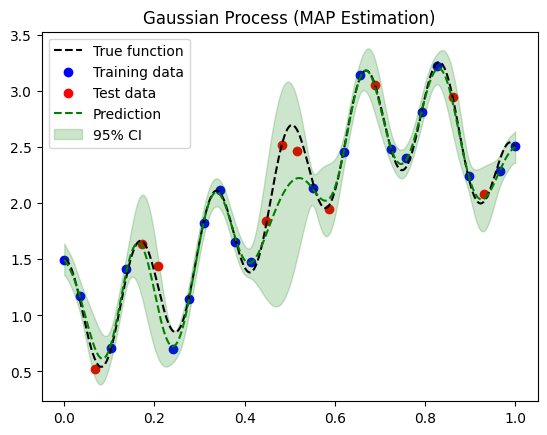

In [ ]:
# Visualization of posterior predictive given the map estimate θ^∗
gp.plot_predict(params=params_map, title="Gaussian Process (MAP Estimation)")

In [ ]:
# Posterior log-likelihood of the test set on the fitted GP using θ^∗
likelihood_test = gp.likelihood_test(params=params_map, log_flag=True)
print(f"Posterior log-likelihood of the test set on the fitted GP using θ^∗:")
print(f"log p(y_test | x_test, x_train, y_train, θ^∗) = {likelihood_test:.4f}")

print(f"\nPosterior likelihood of the test set on the fitted GP using θ^∗:")
print(f"p(y_test | x_test, x_train, y_train, θ^∗) = {torch.exp(likelihood_test):.4f}")

Posterior log-likelihood of the test set on the fitted GP using θ^∗:
log p(y_test | x_test, x_train, y_train, θ^∗) = -1.9944

Posterior likelihood of the test set on the fitted GP using θ^∗:
p(y_test | x_test, x_train, y_train, θ^∗) = 0.1361


### Point 3

/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=3 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(



Sampling posterior with NUTS...


Sample [2]: 100%|██████████| 800/800 [00:52, 15.15it/s, step size=1.65e-01, acc. prob=0.960]
/usr/local/lib/python3.11/dist-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



NUTS Summary (R-hat and ESS):
                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_variance          0.041  0.389  -0.633    0.793      0.015    0.013   
log_lengthscale      -1.620  0.309  -2.233   -1.137      0.016    0.012   
log_period_minus_one -0.615  0.763  -1.998    0.874      0.036    0.026   

                      ess_bulk  ess_tail  r_hat  
log_variance             693.0     605.0   1.01  
log_lengthscale          401.0     412.0   1.00  
log_period_minus_one     437.0     396.0   1.00  
 


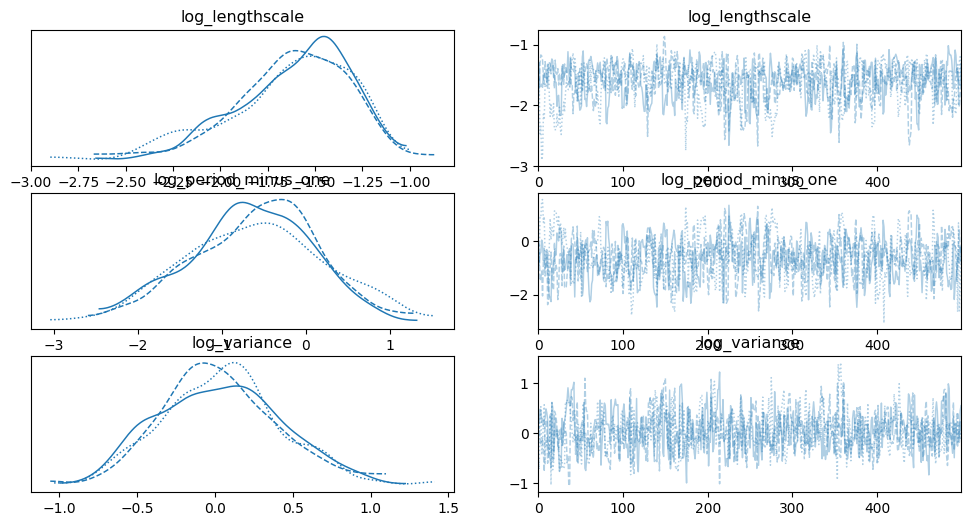

In [ ]:
# NUTS Sampling of the posterior distribution
gp = GaussianProcess(x_train, y_train_raw, x_test, y_test_raw)
print("\nSampling posterior with NUTS...")
posterior_samples_repar, posterior_samples = gp.sample_posterior(num_samples=500, warmup_steps=300, num_chains=3, arviz_flag=True)

In [ ]:
# Print of the means of samples
params_string = ['variance', 'lengthscale', 'period']
params_mean = [posterior_samples[s].mean() for s in params_string]
print(f"Posterior samples:\nVariance mean: {params_mean[0]:.4f} \nLength-scale mean: {params_mean[1]:.4f} \nPeriod mean: {params_mean[2]:.4f}")

Posterior samples:
Variance mean: 1.1260 
Length-scale mean: 0.2070 
Period mean: 1.7165


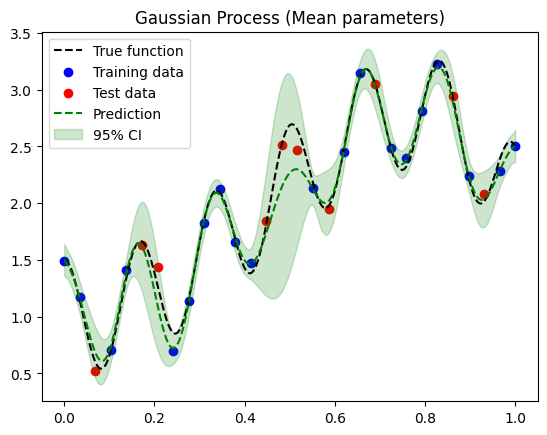

In [ ]:
# Visualization of the posterior predictive using the mean parameters
gp.plot_predict(params=params_mean, title="Gaussian Process (Mean parameters)")

### Point 4

We approximate the posterior likelihood of the samples of the test set in the following way:
\begin{align}
p(y_{\text{test}} \mid X_{\text{test}}, X_{\text{train}}, y_{\text{train}}) &= \int p(y_{\text{test}} \mid X_{\text{test}}, X_{\text{train}}, y_{\text{train}}, \theta) \, p(\theta \mid X_{\text{train}}, y_{\text{train}}) \, d\theta \\
&\approx \dfrac{1}{N} \sum_{i=1}^{N} p( y_{\text{test}} \mid X_{\text{test}},\, X_{\text{train}},\, y_{\text{train}},\, \theta^{(i)} )
\end{align}
where, $\theta^{(i)}, i=1,\dots,M,$ are our samples.

In practice, to improve stability, we compute such approximation with the following steps:


*   Compute the log probabilities
    $$
    \ell (i) = \log p( y_{\text{test}} \mid X_{\text{test}},\, X_{\text{train}},\, y_{\text{train}},\, \theta^{(i)} );
    $$
*   Compute
    $$
    \log S = \log\left( \sum_{i=1}^{N} e^{\ell (i)}\right),
    $$
    in a stable way, using the Pytorch function torch.logsumexp;
*   Compute the logarithm of our approximation as
    $$
    \log S - \log N,
    $$
    (which is mathematically equivalent to $\log(S/N)$;
*   Exponentiate the last result to get our approximation, $S/N$.

In [ ]:
lta = gp.likelihood_test_approx(posterior_samples, log_flag=True)

print(f"Approximate posterior log-likelihood of the samples in the test set using 500 sampled values of θ:")
print(f"log p(y_test | x_test, x_train, y_train) ≈ {lta:.4f}")

print(f"\nApproximate posterior likelihood of the samples in the test set using 500 sampled values of θ:")
print(f"p(y_test | x_test, x_train, y_train) ≈ {torch.exp(lta):.4f}")

Approximate posterior log-likelihood of the samples in the test set using 500 sampled values of θ:
log p(y_test | x_test, x_train, y_train) ≈ -2.1284

Approximate posterior likelihood of the samples in the test set using 500 sampled values of θ:
p(y_test | x_test, x_train, y_train) ≈ 0.1190


### Point 5

Repeat this procedure for 20 different generated datasets for both approaches
and compare the obtained test likelihoods (the code is commented out, it takes more then 1h to run fully; we run it once and saved the results to a pickle file).

In [ ]:
'''
params_string = ['variance', 'lengthscale', 'period']
# List for storing the test likelihooods computed using the map estimate
likelihoods_map = []
# List for storing the approximate posterior likelihoods obtained using the NUTS samples
likelihoods_approx = []

for i in range(20):
    print(f"%%%%%%%%%%%%%%%%%%%%%%%% Dataset {i+1} %%%%%%%%%%%%%%%%%%%%%%%%")
    x_train, y_train_raw, x_test, y_test_raw = generate_dataset(seed=i)
    gp = GaussianProcess(x_train, y_train_raw, x_test, y_test_raw)

    print("Optimizing joint likelihood (MAP estimate)...")
    map_estimate_repar, map_estimate = gp.optimize_log_posterior(num_steps=3000, lr=0.01)
    params_map = [map_estimate[s] for s in params_string]

    likelihood_test = gp.likelihood_test(params=params_map, log_flag=False)
    likelihoods_map.append(likelihood_test)
    print(f"p(y_test | x_test, x_train, y_train, θ^∗) = {likelihood_test:.4f}")

    print("Sampling posterior with NUTS...")
    posterior_samples_repar, posterior_samples = gp.sample_posterior(num_samples=500, warmup_steps=300, num_chains=3)
    lta = gp.likelihood_test_approx(posterior_samples, log_flag=False)
    likelihoods_approx.append(lta)
    print(f"p(y_test | x_test, x_train, y_train) ≈ {lta:.4f}")

from google.colab import files
import pickle

likelihoods_map = [el.cpu().detach().numpy() for el in likelihoods_map]

with open('likelihoods_map.pkl', 'wb') as f:
    pickle.dump(likelihoods_map, f)
files.download('likelihoods_map.pkl')

with open('likelihoods_approx.pkl', 'wb') as f:
    pickle.dump(likelihoods_approx, f)
files.download('likelihoods_approx.pkl')

print("END")
'''

'\nparams_string = [\'variance\', \'lengthscale\', \'period\']\n# List for storing the test likelihooods computed using the map estimate\nlikelihoods_map = []\n# List for storing the approximate posterior likelihoods obtained using the NUTS samples\nlikelihoods_approx = []\n\nfor i in range(20):\n    print(f"%%%%%%%%%%%%%%%%%%%%%%%% Dataset {i+1} %%%%%%%%%%%%%%%%%%%%%%%%")\n    x_train, y_train_raw, x_test, y_test_raw = generate_dataset(seed=i)\n    gp = GaussianProcess(x_train, y_train_raw, x_test, y_test_raw)\n\n    print("Optimizing joint likelihood (MAP estimate)...")\n    map_estimate_repar, map_estimate = gp.optimize_log_posterior(num_steps=3000, lr=0.01)\n    params_map = [map_estimate[s] for s in params_string]\n\n    likelihood_test = gp.likelihood_test(params=params_map, log_flag=False)\n    likelihoods_map.append(likelihood_test)\n    print(f"p(y_test | x_test, x_train, y_train, θ^∗) = {likelihood_test:.4f}")\n\n    print("Sampling posterior with NUTS...")\n    posterior_sam

In [ ]:
from google.colab import files
import pickle

# Download the pickle file from the raw URL
raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/likelihoods_map.pkl'
!wget -O likelihoods_map.pkl {raw_url}
with open('likelihoods_map.pkl', 'rb') as file:
    likelihoods_map = pickle.load(file)

raw_url = 'https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/likelihoods_approx.pkl'
!wget -O likelihoods_approx.pkl {raw_url}
with open('likelihoods_approx.pkl', 'rb') as file:
    likelihoods_approx = pickle.load(file)

--2025-01-17 16:22:14--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/likelihoods_map.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 741 [application/octet-stream]
Saving to: ‘likelihoods_map.pkl’

likelihoods_map.pkl 100%[===================>]     741  --.-KB/s    in 0s      

2025-01-17 16:22:14 (38.6 MB/s) - ‘likelihoods_map.pkl’ saved [741/741]

--2025-01-17 16:22:15--  https://raw.githubusercontent.com/GioLombardi/PML-Final-Project/main/data/likelihoods_approx.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

Plot of the likelihoods.

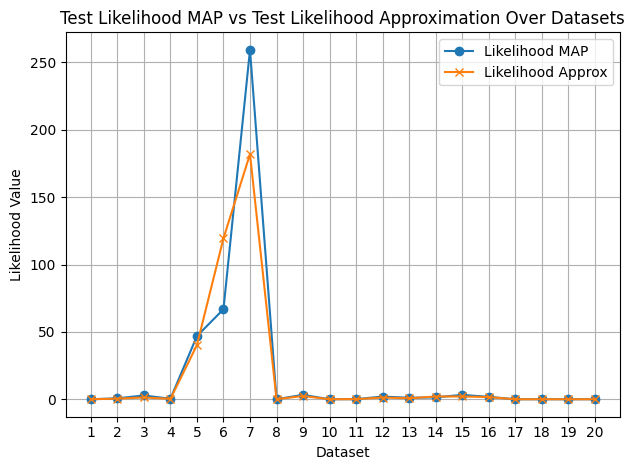

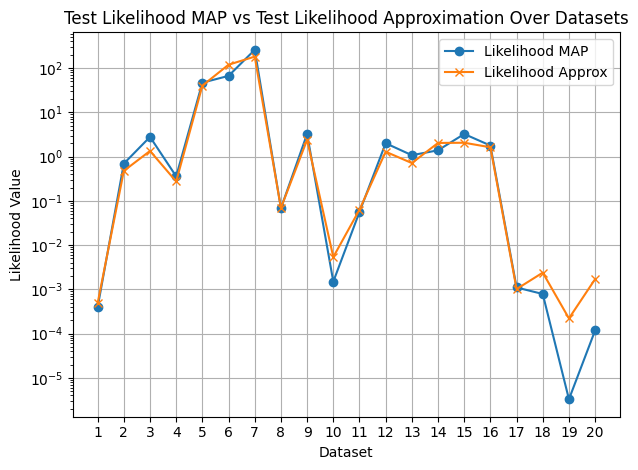

In [ ]:
# Generate indices for the x-axis
indices = list(range(1, len(likelihoods_map)+1))

# Create the plot
plt.figure()
plt.plot(indices, likelihoods_map, label='Likelihood MAP', marker='o')
plt.plot(indices, likelihoods_approx, label='Likelihood Approx', marker='x')

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Likelihood Value')
plt.xticks(indices)
plt.title('Test Likelihood MAP vs Test Likelihood Approximation Over Datasets')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

print(' ')

# Create the plot
plt.figure()
plt.semilogy(indices, likelihoods_map, label='Likelihood MAP', marker='o')
plt.semilogy(indices, likelihoods_approx, label='Likelihood Approx', marker='x')

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Likelihood Value')
plt.xticks(indices)
plt.title('Test Likelihood MAP vs Test Likelihood Approximation Over Datasets')
plt.legend()
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

Comparison of mean and std.

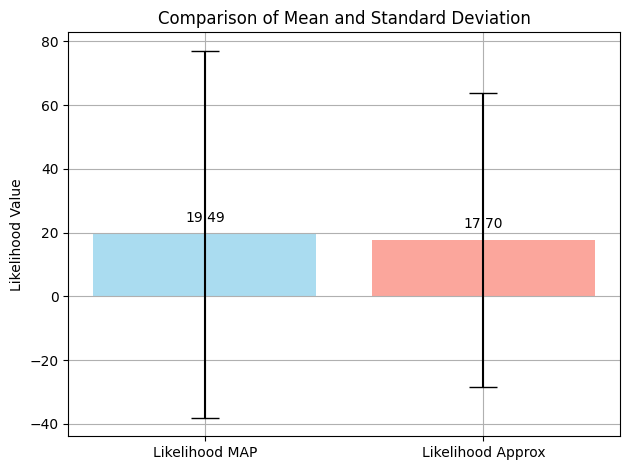

In [ ]:
# Calculate mean and standard deviation
map_mean = np.mean(likelihoods_map)
approx_mean = np.mean(likelihoods_approx)

map_std = np.std(likelihoods_map)
approx_std = np.std(likelihoods_approx)

# Data for plotting
categories = ['Likelihood MAP', 'Likelihood Approx']
means = [map_mean, approx_mean]
stds = [map_std, approx_std]

# Create the bar plot
plt.figure()
bars = plt.bar(categories, means, yerr=stds, capsize=10, color=['skyblue', 'salmon'], alpha=0.7)

# Add titles and labels
plt.ylabel('Likelihood Value')
plt.title('Comparison of Mean and Standard Deviation')

# Annotate bars with mean values
for bar, mean in zip(bars, means):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + stds[0]*0.05, f'{mean:.2f}', ha='center', va='bottom')

plt.grid(True)
plt.tight_layout()
plt.show()

# Problem B.2

### Point 1

To derive the distribution of $(\hat{q}, f) | X$:
   - Define $f = [f(x_1), \ldots, f(x_\ell)]^T$ and $w = [w_1, \ldots, w_\ell]^T$.
   - Write
   $$
   \hat{q} = \sum_{i=1}^{\ell} w_i f(x_i) = \hat{q} = w^T f.
   $$
   - It follows that
   $$
   \begin{bmatrix}
   \hat{q} \\ f
   \end{bmatrix}
   = \begin{bmatrix}
   w^T \\
   I_\ell
   \end{bmatrix}
   f,
   $$
   where $I_\ell$ denotes the identity matrix of order $\ell$.
   - Since $f \sim \mathcal{N}(0, K)$, where $K_{ij} = k(x_i, x_j)$, by the properties of the normal distribution (see e.g. Oswin's notes, pag. 11), we get
   $$
  \begin{bmatrix}
   \hat{q} \\ f
   \end{bmatrix}
  \sim \mathcal{N} \left(
  0,
  \begin{bmatrix}
  w^T \\ I_\ell
  \end{bmatrix}
  K
  \begin{bmatrix}
  w & I_\ell
  \end{bmatrix}
  \right).
  $$
  That is,
  $$
  (\hat{q}, f) | X
  \sim \mathcal{N} \left(
  0,
  \begin{bmatrix}
  w^T K w & w^T K \\
  K w & K
  \end{bmatrix}
  \right).
  $$

### Point 2

Since the vector $(\hat{q}, f) | X$ is normally distributed, using the properties of the normal distribution we can compute $f|X,\hat{q}$ (precisely, we are using equation (29) on pag. 9 of the notes by Oswin). We get
$$
f | X, \hat{q} \sim \mathcal{N}( \mu, \Sigma)
$$
with
\begin{align}
\mu &= K w (w^T K w)^{-1} \hat{q}, \\
\Sigma &= K - K w (w^T K w)^{-1} w^T K.
\end{align}

The covariance matrix is not full rank. Indeed, the vector $w$ belongs to the kernel of such matrix:
\begin{align}
\Sigma w &= Kw - K w (w^T K w)^{-1} (w^T Kw)\\
&= Kw - K w = 0.
\end{align}

### Point 3

To sample from the normal distribution $\mathcal{N}( \mu, \Sigma)$, we cannot simply call

```python
mvn = dist.MultivariateNormal(mu, covariance_matrix=Sigma)
samples = mvn.sample(sample_shape=(n_samples,))
```

because the covariance matrix $\Sigma$ is not positive definite. To solve the problem, we add independent gaussian noise to the distribution to reguarize it:

```python
Sigma += reg * torch.eye(Sigma.size(0))
```

Since we want to add the least amount of noise possible, we start with a small parameter ```reg = 1e-6``` and increase it until $\Sigma$ becomes positive definite.

In [ ]:
# Define a function to implement the Trapezoidal rule
def compute_weights(l):
    '''
    Compute the weights for the integral approximation.
    Args:
    l (int): The number of points to use in the integral approximation.
    Returns:
    w (torch.Tensor): The weights for the integral approximation, of shape (l,).
    '''
    w = torch.full((l,), 1 / (l - 1), device=device)
    w[0] = w[-1] = 1 / (2 * (l - 1))
    return w

def approximate_integral(f, x):
    '''
    Approximate the integral of a function f(x) over a given interval [0, 1].
    Args:
    f (callable): The function to integrate.
    x (torch.Tensor): The points at which to evaluate the function.
    Returns:
    q_hat (torch.Tensor): The approximate value of the integral.
    '''
    l = len(x)
    w = compute_weights(l)
    q_hat = sum(w[i] * f(x[i]) for i in range(l))
    return q_hat

In [ ]:
class GaussianProcessIntegral(GaussianProcess):
    def __init__(self, x_train, y_train, x_test, y_test, q_hat_raw, params_map, noise_variance=0.01):
        super().__init__(x_train, y_train, x_test, y_test, noise_variance=noise_variance)
        self.params_map = params_map
        self.q_hat_raw = q_hat_raw

        self.q_hat = (q_hat_raw - self.y_train_mean) / self.y_train_std

    def conditional_integral(self, q_hat=None, ell=101):
        '''
        Compute the distribution of the gaussian process given ell (the number of points of the X grid, x_hat), the integral value q_hat, and the parameters θ^∗.
        Args:
        q_hat (torch.Tensor): The integral value.
        ell (int): The number of points to use in the integral approximation.
        Returns:
        mu_hat (torch.Tensor): The mean of the gaussian process.
        Sigma_hat (torch.Tensor): The covariance matrix of the gaussian process.
        '''
        if q_hat is None:
            q_hat = self.q_hat

        x_hat = torch.linspace(0, 1, ell, device=self.device)
        w = compute_weights(ell).view(-1, 1)  # Make sure w is a column vector
        K = self.per_kernel(x_hat, *self.params_map)

        K = K + K.t() / 2 #Ensure symmetry

        K_w = K @ w
        w_T_K_w = w.t() @ K_w
        w_T_K_w_inv = 1.0 / w_T_K_w

        mu_hat = K_w * w_T_K_w_inv * q_hat
        Sigma_hat = K - K_w @ (w_T_K_w_inv * K_w.t())

        Sigma_hat = Sigma_hat + Sigma_hat.t() / 2 #Ensure symmetry

        return mu_hat.squeeze(-1), Sigma_hat

    def print_samples_integral(self, q_hat=None, ell=101, n_samples=5):
        '''
        Print samples from the gaussian process given ell (the number of points of the X grid, x_hat), the integral value q_hat, and the parameters θ^∗.
        Args:
        q_hat (torch.Tensor): The integral value.
        ell (int): The number of points to use in the integral approximation.
        n_samples (int): The number of samples to print.
        '''
        if q_hat is None:
            q_hat = self.q_hat

        mu_hat, Sigma_hat = self.conditional_integral(q_hat, ell)

        # Regularization
        reg = 1e-6
        max_reg = 1e-1
        Sigma_hat_reg = Sigma_hat.clone()
        Sigma_hat_reg = Sigma_hat + reg * torch.eye(Sigma_hat.size(0)).to(self.device)

        while True:
            try:
                # Attempt Cholesky decomposition
                L = torch.linalg.cholesky(Sigma_hat_reg)
                print(f'Sigma succesfully tranformed into a positive definite matrix with regularization {reg: .0e}.')
                break  # Success, exit loop
            except:
                # Covariance matrix is not positive definite
                reg *= 10
                Sigma_hat_reg = Sigma_hat + reg * torch.eye(Sigma_hat.size(0)).to(self.device)

            if reg > max_reg:
                raise RuntimeError("Covariance matrix is not positive definite even after regularization.")

        mvn = dist.MultivariateNormal(mu_hat, covariance_matrix=Sigma_hat_reg)
        samples = mvn.sample(sample_shape=(n_samples,))

        plt.figure()
        x_hat = np.linspace(0,1, ell)
        for i in range(n_samples):
            plt.plot(x_hat, samples[i].cpu().detach().numpy())
        title = "5 samples from $f|X,\hat{q}$ with $\hat{q}$ = " + str(q_hat)
        plt.title(title)
        plt.xlabel("$X$")
        plt.ylabel("$f_X$")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    def conditional_integral_with_data(self, q_hat=None, ell=101):
        '''
        Compute the distribution of the GP at x_hat given the integral value q_hat,
        the observed data (x_train, y_train), and the parameters θ^∗.

        Parameters:
        - q_hat: The observed integral value (scalar).
        - ell: Number of integration points.
        - sigma_q: Small noise variance added to the integral constraint.

        Returns:
        - mu_f_given_yq: Conditional mean at x_hat.
        - Sigma_f_given_yq: Conditional covariance matrix at x_hat.
        '''
        if q_hat is None:
            q_hat = self.q_hat

        # Define integration points x_hat and weights w
        x_hat = torch.linspace(0, 1, ell).to(self.device)
        w = compute_weights(ell).view(-1, 1).to(self.device)

        # Number of points
        n_f = x_hat.size(0)
        n_y = self.x_train.size(0)


        # Compute covariance matrices
        K_ff = self.per_kernel(x_hat, *self.params_map)  # [n_f x n_f]
        K_ff = (K_ff + K_ff.t()) / 2  # Ensure symmetry

        K_fy = self.per_kernel(x_hat, *self.params_map, X2=self.x_train)  # [n_f x n_y]

        K_yy = self.per_kernel(self.x_train, *self.params_map)  # [n_y x n_y]
        K_yy = (K_yy + K_yy.t()) / 2
        K_yy += self.noise_variance * torch.eye(n_y).to(self.device)  # Add noise variance

        # Covariance with the integral constraint
        K_fq = K_ff @ w  # [n_f x 1]
        K_yq = K_fy.t() @ w  # [n_y x 1]
        K_qq = w.t() @ K_ff @ w  # [1 x 1], scalar

        # Build the joint covariance matrix Sigma_yq_yq = [[K_yy, K_yq], [K_yq^T, K_qq]]
        Sigma_yq_yq = torch.cat([
            torch.cat([K_yy, K_yq], dim=1),
            torch.cat([K_yq.t(), K_qq], dim=1)
        ], dim=0)  # [ (n_y + 1) x (n_y + 1) ]

        # Ensure symmetry
        Sigma_yq_yq = (Sigma_yq_yq + Sigma_yq_yq.t()) / 2

        # Build the cross-covariance matrix Sigma_fyq = [K_fy, K_fq]
        Sigma_fyq = torch.cat([K_fy, K_fq], dim=1)  # [n_f x (n_y + 1)]

        # Observations vector
        y_obs = torch.cat([self.y_train, q_hat.view(1,)]).to(self.device)  # [n_y + 1]

        # Regularization to ensure invertibility
        Sigma_yq_yq += 1e-6 * torch.eye(n_y + 1).to(self.device)

        # Solve the linear system to find alpha = Sigma_yq_yq^-1 * y_obs
        alpha = torch.linalg.solve(Sigma_yq_yq, y_obs)  # [n_y + 1]

        # Compute the conditional mean
        mu_f_given_yq = Sigma_fyq @ alpha  # [n_f]

        # Solve the linear system to find V = Sigma_yq_yq^-1 * Sigma_fyq.t()
        V = torch.linalg.solve(Sigma_yq_yq, Sigma_fyq.t())  # [n_y + 1 x n_f]
        Sigma_f_given_yq = K_ff - Sigma_fyq @ V  # [n_f x n_f]

        # Ensure symmetry
        Sigma_f_given_yq = (Sigma_f_given_yq + Sigma_f_given_yq.t()) / 2

        return mu_f_given_yq, Sigma_f_given_yq

    def plot_predict_with_integral(self, q_hat=None, ell=101):
        '''
        Plot the distribution of the GP at x_hat given the integral value q_hat,
        the observed data (x_train, y_train), and the parameters θ^∗.
        Args:
        q_hat (torch.Tensor): The integral value.
        ell (int): The number of points to use in the integral approximation.
        '''
        if q_hat is None:
            q_hat = self.q_hat

        mu_f_given_yq, Sigma_f_given_yq = self.conditional_integral_with_data(q_hat, ell)
        var = torch.diag(Sigma_f_given_yq)

        # Plotting results
        plt.figure()
        x_hat = torch.linspace(0, 1, ell)
        plt.plot(x_hat, g(x_hat), 'k--', label='True function')
        plt.scatter(self.x_train.cpu(), self.y_train_raw.cpu(), color='blue', label='Training data')

        y_out_mean = mu_f_given_yq * self.y_train_std + self.y_train_mean
        y_out_mean = y_out_mean.cpu().detach().numpy()
        y_out_var = var * self.y_train_std**2
        y_out_var = y_out_var.cpu().detach().numpy()
        plt.plot(x_hat, y_out_mean, 'g--', label='Prediction')
        plt.fill_between(x_hat,
                         y_out_mean + 1.96 * np.sqrt(y_out_var),
                         y_out_mean - 1.96 * np.sqrt(y_out_var),
                         color='green', alpha=0.2, label='95% CI')

        plt.legend()
        plt.title("title")
        plt.show()

Print 5 samples from $f|X,\hat{q}$ for different integral values.

q_hat =  0
Sigma succesfully tranformed into a positive definite matrix with regularization  1e-05.


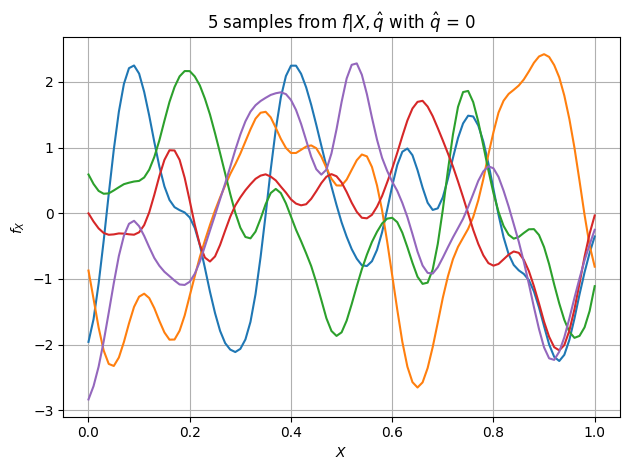

 
q_hat =  5
Sigma succesfully tranformed into a positive definite matrix with regularization  1e-05.


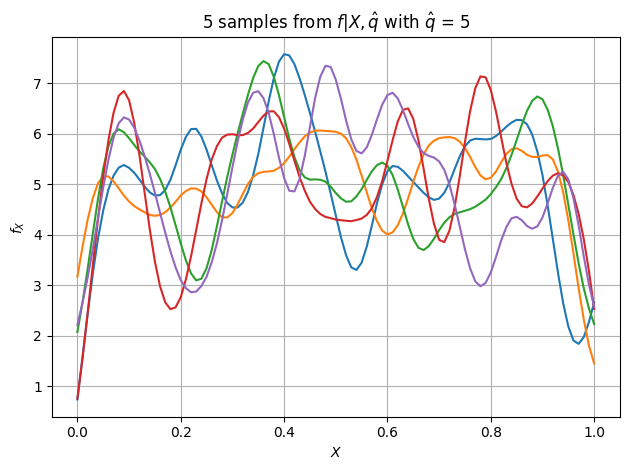

 
q_hat =  10
Sigma succesfully tranformed into a positive definite matrix with regularization  1e-05.


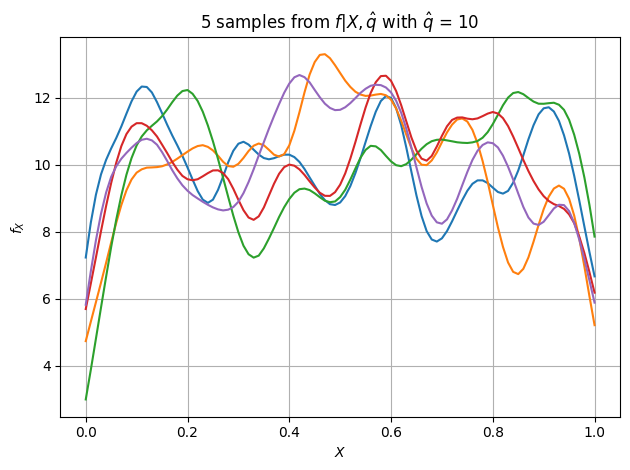

In [ ]:
x_train, y_train_raw, x_test, y_test_raw = generate_dataset() #we generate a dataset to create the gp instance (it is required by the __init__ method), altough we don't really use it
q_hat_raw = torch.tensor(0).to(device) #we define a integral value to create the instance, altough we don't really use it

gp_int = GaussianProcessIntegral(x_train, y_train_raw, x_test, y_test_raw, q_hat_raw, params_map)

for q in [0, 5, 10]:
    print(f'q_hat = {q: d}')
    gp_int.print_samples_integral(q)
    print(' ')

### Point 4

Let's derive the distribution of $f|\hat{q}, \mathcal{D}$, using the properties of the Gaussian distribution.

- Denote $x = [x_1,\dots,x_\ell]^T$ the $x$ values for the integral approximation, $\tilde{x} = [\tilde{x}_1,\tilde{x}_2, \tilde{x}_3]^T$ the $x$ values of the points in the dataset $\mathcal{D}$. Denote also $f = [f(x_1),\dots,f(x_\ell)]^T$, $\tilde{f} = [f(\tilde{x}_1), f(\tilde{x}_2), f(\tilde{x}_3)]^T$ and $w = [w_1,\dots,w_\ell]^T$.

- By the properties of the Gaussian process, we have:
$$
\begin{bmatrix}
  \tilde{f} \\ f
\end{bmatrix}
\sim \mathcal{N} \left(
0,
\begin{bmatrix}
K_{\tilde{f}\! \tilde{f}} & K_{\tilde{f}\! f} \\
K_{f \tilde{f}} & K_{f f}
\end{bmatrix}
\right),
$$
where
\begin{align}
(K_{\tilde{f}\! \tilde{f}})_{ij} &= k(\tilde{x}_i, \tilde{x}_j), \\
(K_{\tilde{f}\! f})_{ij} &= k(\tilde{x}_i, x_j), \\
(K_{f \tilde{f}})_{ij} &= k(x_i, \tilde{x}_j), \\
(K_{f f})_{ij} &= k(x_i, x_j).
\end{align}

- Since $y = \tilde{f} + \epsilon$, with $\epsilon \sim \mathcal{N}(0, \sigma_y)$ independent Gaussian noise, we have
$$
\begin{bmatrix}
  y \\ f
\end{bmatrix} =
\begin{bmatrix}
  \tilde{f} \\ f
\end{bmatrix} +
\begin{bmatrix}
  \epsilon \\ 0
\end{bmatrix}
\sim \mathcal{N} \left(
0,
\begin{bmatrix}
K_{y y} & K_{y f} \\
K_{f y} & K_{f f}
\end{bmatrix}
\right),
$$
with
\begin{align}
K_{y y} &= K_{\tilde{f}\! \tilde{f}} + \sigma_y I_3, \\
K_{y f} &= K_{f y}^T = K_{\tilde{f}\! f} = K_{f \tilde{f}}^T.
\end{align}

- Similarly as we saw before, we have
  $$
  \begin{bmatrix}
  y \\ \hat{q} \\ f
  \end{bmatrix}
   = \left[
  \begin{array}{c|c}
  I_3 & 0 \\ \hline
  0 & w^T \\ \hline
  0 & I_\ell
  \end{array}
  \right]
  \begin{bmatrix}
  y  \\ f
  \end{bmatrix}
  \sim \mathcal{N}
  \left( 0,
  \left[
  \begin{array}{c|c|c}
  K_{yy} & K_{yf}w & K_{yf} \\ \hline
  w^T K_{fy} & w^TK_{ff}w & w^T K_{ff}\\ \hline
  K_{fy} & K_{ff} w & K_{ff}
  \end{array}
  \right]
  \right)
  $$

- Introducing the notations
  \begin{align}
  K_{yq,yq} &=
  \left[
  \begin{array}{c c}
  K_{yy} & K_{yf}w \\
  w^T K_{fy} & w^TK_{ff}w
  \end{array}
  \right], \\
  K_{yq,f} &=
  \left[
  \begin{array}{c}
  K_{yf} \\
  w^T K_{ff} \\
  \end{array}
  \right]
  = K_{f, yq} ^T, \\
  v_{yq} &=
  \left[
  \begin{array}{c}
  y \\
  \hat{q} \\
  \end{array}
  \right],
  \end{align}
  we have
  $$
  \begin{bmatrix}
  y \\ \hat{q} \\ f
  \end{bmatrix} =
  \begin{bmatrix}
  v_{yq} \\ f
  \end{bmatrix}
  \sim \mathcal{N}
  \left( 0,
  \left[
  \begin{array}{c c}
  K_{yq,yq} & K_{yq,f} \\
  K_{f, yq} & K_{ff}
  \end{array}
  \right]
  \right).
  $$

- Thus, using angain the properties of the Gaussian distribution (see Oswin's notes, pag. 11), we have $f|\hat{q}, \mathcal{D} \sim \mathcal{N}(\mu, \Sigma)$ with
\begin{align}
\mu &= K_{f,yq} K_{yq,yq}^{-1}v_{yq}, \\
\Sigma &= K_{ff} - K_{f,yq} K_{yq,yq}^{-1} K_{yq, f}.
\end{align}

These computetions were implemented in the method ```conditional_integral_with_data``` above.



Visual comparison of $f|\hat{q}, \mathcal{D}$ and $f|\mathcal{D}$, for the diven dataset:

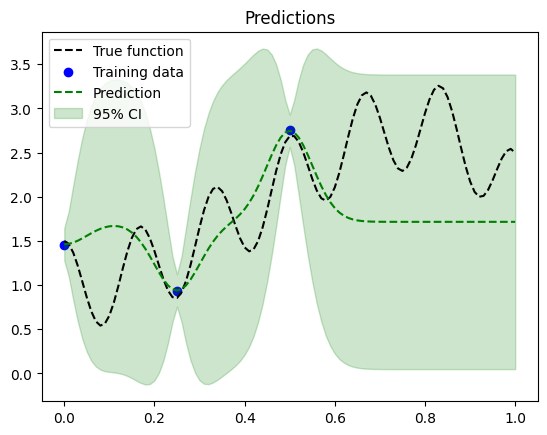

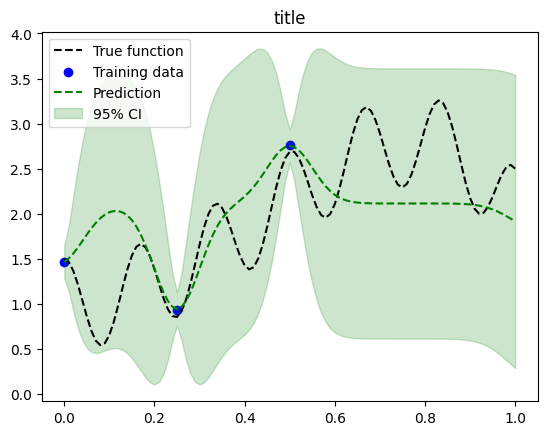

In [ ]:
# Load the dataset
ell = 101
x_hat = torch.linspace(0, 1, ell).to(device)
q_hat_raw = torch.tensor(2).to(device)
x_train = torch.tensor([0, 0.25, 0.5]).to(device)
y_train_raw = torch.tensor([1.46, 0.93, 2.76]).to(device)
x_test = torch.tensor([0]).to(device) # Dummy test values (we need them to create the instance)
y_test_raw = torch.tensor([1.46]).to(device)

gp_int = GaussianProcessIntegral(x_train, y_train_raw, x_test, y_test_raw, q_hat_raw, params_map)

gp_int.plot_predict(x_predict=x_hat, params=params_map, plot_test=False)

print(' ')

gp_int.plot_predict_with_integral(ell=101)

The plots above doesn't seem very informative. To better appreciate the improvement of the predictions given the integral contraint, we consider a richer dataset:

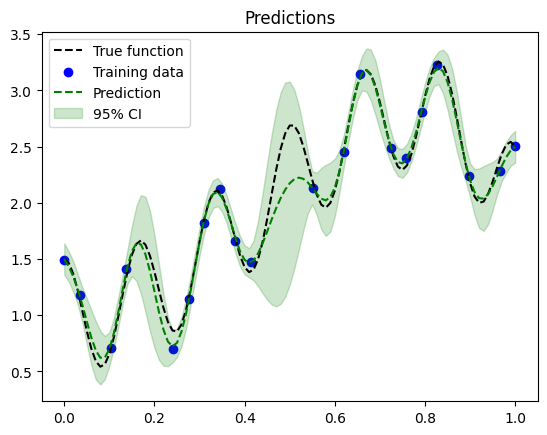

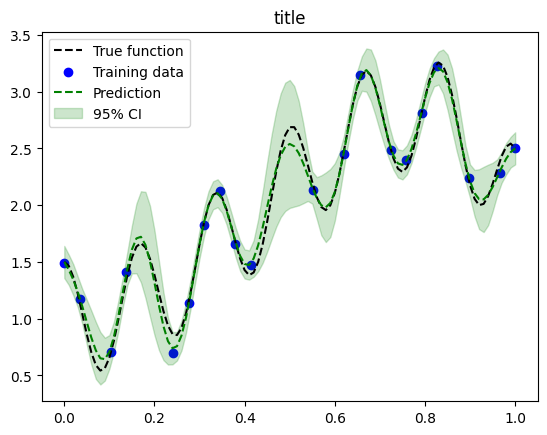

In [ ]:
# Load the dataset
ell = 101
x_hat = torch.linspace(0, 1, ell).to(device)
q_hat_raw = torch.tensor(2).to(device)
x_train, y_train_raw, x_test, y_test_raw = generate_dataset()

gp_int = GaussianProcessIntegral(x_train, y_train_raw, x_test, y_test_raw, q_hat_raw, params_map)

gp_int.plot_predict(x_predict=x_hat, params=params_map, plot_test=False)

print(' ')

gp_int.plot_predict_with_integral(ell=101)